In [1]:
import os
import numpy as np
import pandas as pd
import Image_finder
import cv2
import pickle
from matplotlib import pyplot as plt

In [2]:
proj_loc = os.path.join(os.getcwd(),"faces_resized\\")

# Compiling list of images in proj_loc directory
a = Image_finder.Image_finder(directory=proj_loc)

# Creating a list of files with resolutions greater than 100x100
img_list = np.array([cv2.imread(file).astype('uint8') for file in a.file_lst()])/255

---------- Imagefinder ----------
No. directories: 1
No. files: 855


In [3]:
img_list.shape[1:]

(200, 200, 3)

In [4]:
import keras
from keras.models import Model
#from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,UpSampling2D, BatchNormalization, Reshape, Input
from keras.layers import *
from keras.optimizers import *
from keras.metrics import *
from keras.models import load_model

Using TensorFlow backend.


In [5]:
''' Method to plot loss in real time'''
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    ''' Method to plot fit progress. '''
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.yscale('log')
        plt.show();
        
plot_losses = PlotLosses()



In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Vae

In [7]:
int_dim1 = 1000
int_dim2 = 500
latent_dim = 2

norm = img_list.size

In [8]:
''' Encoding the images '''
input_ = Input(shape=img_list.shape[1:])

enc_0 = Conv2D(filters=32 ,kernel_size=(3,3) ,padding='same', activation='relu')(input_)
enc_1 = MaxPooling2D(pool_size=(2, 2))(enc_0)

enc_2 = Conv2D(filters=18 ,kernel_size=(3,3) ,padding='same', activation='relu')(enc_1)
enc_3 = MaxPooling2D(pool_size=(2, 2))(enc_2)

enc_4 = Conv2D(filters=12 ,kernel_size=(3,3) ,padding='same', activation='relu')(enc_3)
enc_5 = MaxPooling2D(pool_size=(2, 2))(enc_4)

int_1 = Flatten()(enc_5)
int_2 = Dense(2000)(int_1)
int_3 = Dense(500)(int_2)

z_mean = Dense(2)(int_3)
z_sigma = Dense(2)(int_3)

# Sampling from a gaussian distribution to add some randomness to the latent vector
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0.,stddev=1.0)
    return z_mean + K.exp(z_sigma/2) * epsilon

z = Lambda(sampling)([z_mean, z_sigma])

''' Decoding the images '''
gen_input_ = Input(shape=(K.int_shape(z)[1:]), name="Input")
gen_1 = Dense(500)(gen_input_)
gen_2 = Dense(2000)(gen_1)
gen_3 = Dense(7500)(gen_2)
gen_4 = Reshape((25, 25, 12))(gen_3)
gen_5 = Conv2D(filters=12 ,kernel_size=(3,3), padding='same', activation='relu')(gen_4)
gen_6 = UpSampling2D((2, 2),interpolation='bilinear')(gen_5)
gen_7 = Conv2D(filters=18 ,kernel_size=(3,3) ,padding='same', activation='relu')(gen_6)
gen_8 = UpSampling2D((2, 2),interpolation='bilinear')(gen_7)
gen_9 = Conv2D(filters=32 ,kernel_size=(3,3) ,padding='same', activation='relu')(gen_8)
gen_10 = UpSampling2D((2, 2),interpolation='bilinear')(gen_9)
x = Conv2D(filters=3 ,kernel_size=(3,3), padding='same', activation='relu')(gen_10)

generator = Model(gen_input_, x)

z_decoded = generator(z)

vae = Model(input_,z_decoded)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 100, 100, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 18) 5202        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [9]:
def vae_loss(input_, output_):
    # Reconstruction loss
    encode_loss = K.mean(binary_crossentropy(input_,output_))
    
    gauss_loss = - 0.5 * K.sum(1 + z_sigma - K.square(z_mean) - K.exp(z_sigma), axis=-1)
    
    return K.sum(encode_loss + gauss_loss)

In [10]:
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [12]:
vae.fit(x=img_list, y=img_list, epochs=100, shuffle=True)

Epoch 1/100
855/855 [==============================] - 6s 7ms/step - loss: 9.5372A: 1s - loss:  - ETA: 0s - loss: 9.54
Epoch 2/100
855/855 [==============================] - 5s 6ms/step - loss: 9.5366A: 3s - loss: 9. - ETA: 3s - - ETA: 0s - loss: 9.
Epoch 3/100
855/855 [==============================] - 5s 6ms/step - loss: 9.5365A: 4s - loss: 9. - ETA: 3s - loss:  - ETA: 2s
Epoch 4/100
855/855 [==============================] - 5s 6ms/step - loss: 4.5726
Epoch 5/100
855/855 [==============================] - 5s 6ms/step - loss: 1.7398A: 4s - loss: 0.8 - ETA: 4s - l - ETA: 2s - l
Epoch 6/100
855/855 [==============================] - 5s 6ms/step - loss: 0.8445A: 2s - loss: 0. - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.8
Epoch 7/100
855/855 [==============================] - 5s 6ms/step - loss: 0.6792A: 4s -  - ETA: 2s -  - ETA: 0s - loss: 0.679
Epoch 8/100
855/855 [==============================] - 5s 6ms/step - loss: 0.6733A: 3s - loss - ETA: 1s - loss: 0.6 - ETA: 1s - loss:
Epoch 9/100


In [13]:
# Save model
#vae.save('vae.h5')
#vae = load_model('vae.h5')

(2600, 2600, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


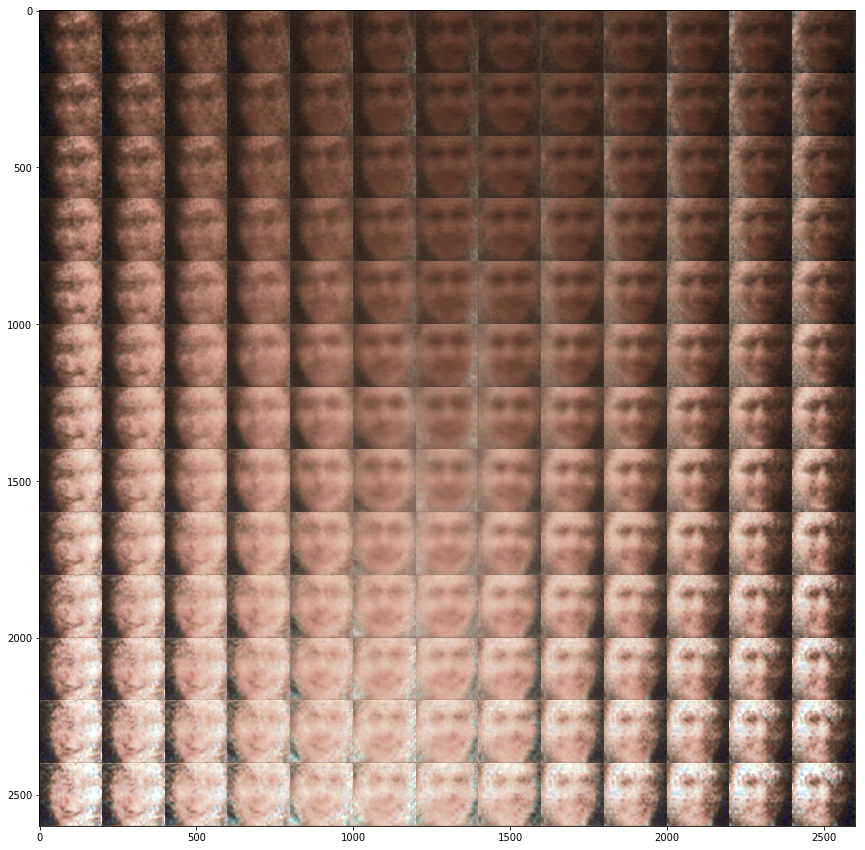

In [14]:
# display a 2D manifold of the digits
n = 13  # figure with 15x15 digits
digit_size = 200
epsilon_std = 1.0

figure = np.zeros((digit_size * n, digit_size * n,3))
print(figure.shape)
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        gen_img = generator.predict(z_sample)
        
        digit = gen_img[0][:,:,::-1]

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        

plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()